In [12]:
##################################################
# Eventstudy.py (PYTHON)
# WRDs address: /home/insead/wentworthliu/Research/Year1/Event_replicate
# by Xinyu
##################################################

import pandas as pd
import numpy as np
import wrds
import datetime as dt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 50)
import os
import json
import matplotlib.pyplot as plt
from datetime import datetime
###################
# Connect to WRDS #
###################
conn=wrds.Connection()

Loading library list...
Done


In [13]:
# Load the original input downloaded from WRDs key developemnt
direct = os.path.realpath('.')
filename = os.path.join(direct, 'Data','eventdate20.csv')
eventdate = pd.read_csv(filename,parse_dates=['announcedate'])
varlist = ['announcedate','gvkey']
eventdate = eventdate[varlist]
eventdate.dropna(inplace=True)
eventdate.reset_index(drop=True,inplace=True)
eventdate.rename(columns={'announcedate':'datadate'},inplace=True)

In [14]:
#######################
# Dataset 1           #
# CCM Block           #
#######################
# Load CCM link table
varlist = "gvkey, lpermno, linkdt, linkenddt"
dataset = "crsp.ccmxpf_linktable"
ccm=conn.raw_sql(f"""
                    select {varlist}
                    from {dataset}
                    where substr(linktype,1,1)='L'
                    and (linkprim ='C' or linkprim='P')
                    """, date_cols=['linkdt','linkenddt'])
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today')+MonthEnd(0)).dt.date
ccm['gvkey']= ccm['gvkey'].astype(int)

In [18]:
# Merge comp with ccm to get a merged df
eventdate_m=pd.merge(eventdate,ccm,how='left',on=['gvkey'])
eventdate_m['yearend']=eventdate_m['datadate']+YearEnd(0)
eventdate_m['jdate']=eventdate_m['yearend']+MonthEnd(6)
# set link date bounds
eventdate_m=eventdate_m[(eventdate_m['jdate']>=eventdate_m['linkdt'])&(eventdate_m['jdate']<=eventdate_m['linkenddt'])]

In [19]:
# Adjust the data to required format and output
varlist = ['datadate','lpermno']
eventdate_m = eventdate_m[varlist]
eventdate_m.rename(columns={'lpermno':'permno','datadate':'edate'},inplace=True)
eventdate_m.reset_index(drop=True,inplace=True)
eventdate_m['edate'] = eventdate_m['edate'].dt.strftime('%m/%d/%Y')
varlist = ['permno','edate']
eventdate_m = eventdate_m[varlist]
eventdate_m['permno'] = eventdate_m['permno'].astype(int)
evtstudy = eventdate_m.to_dict('records')
direct = os.path.realpath('.')
filename = os.path.join(direct, 'Data','evtstudy-sample.json')
with open(filename, 'w') as event:
    json.dump(evtstudy, event)

In [20]:
# Data manipulation to plot the bar plot 

eventdate_m['edate'] = pd.to_datetime(eventdate_m['edate'])
eventdate_m['year']=eventdate_m['edate'].dt.year
summary = pd.DataFrame()
summary['com'] = eventdate_m.groupby('year')['permno'].nunique()
summary['case']=eventdate_m.groupby('year')['permno'].count()
summary['dens'] = summary['case']/summary['com']

temp = eventdate_m.groupby(['year','permno']).count()==1
summary['case==1'] = temp.groupby('year').sum()
temp = eventdate_m.groupby(['year','permno']).count()==2
summary['case==2'] = temp.groupby('year').sum()*2
temp = eventdate_m.groupby(['year','permno']).count()==3
summary['case==3'] = temp.groupby('year').sum()*3
summary['case>=4'] = summary['case'] - summary['case==1'] - summary['case==2']- summary['case==3']

In [21]:
summary

,com,case,dens,case==1,case==2,case==3,case>=4
year,,,,,,,
2001,88,99,1.125000,78,18,3,0
2002,842,2043,2.426366,480,304,243,1016
2003,1129,3546,3.140833,583,398,306,2259
2004,1247,3765,3.019246,610,426,348,2381
2005,1099,3262,2.968153,518,456,294,1994
2006,1037,3022,2.914176,534,400,261,1827
2007,1101,3715,3.374205,517,432,321,2445
2008,1045,3170,3.033493,519,438,288,1925
2009,1071,3451,3.222222,494,428,369,2160


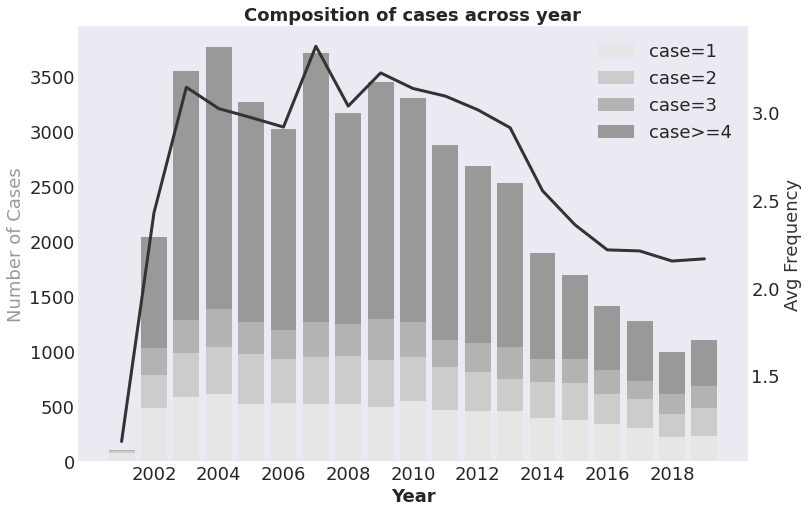

In [23]:
# Plot block
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111)
plt.style.use('seaborn-dark')
colormap = plt.cm.get_cmap('twilight') 
ax.tick_params(labelsize=18) # set both x and y axes tick size to 18
ax.set_xticks(summary.index[1:20:2])

plt.xlabel('Year', fontsize=18, fontweight='bold')
plt.title('Composition of cases across year', fontsize=18, fontweight='bold')
ax.bar(summary.index, summary['case==1'],color=".9",label='case=1')
ax.bar(summary.index, summary['case==2'],color=".8", bottom=summary['case==1'],label='case=2')
ax.bar(summary.index, summary['case==3'],color=".7", bottom=summary['case==2']+summary['case==1'],label='case=3')
ax.bar(summary.index, summary['case>=4'],color=".6", bottom=summary['case==3']+summary['case==2']+summary['case==1'],label='case>=4')
ax.set_ylabel("Number of Cases",fontsize=18,c=".6")
ax.legend(fontsize=18)
ax2=ax.twinx()
ax2.tick_params(labelsize=18)
ax2.plot(summary.index, summary['dens'],c=".2", linewidth=3)
# ax2.axhline(summary['dens'].mean(), linestyle='--', c='r')
ax2.set_ylabel("Avg Frequency",color=".2",fontsize=18)
plt.savefig('./Plot/hist_case.png')

In [24]:
# Analyze the result from Eventstudy
direct = os.path.realpath('.')
filename = os.path.join(direct, 'Output','EventStudy_stats.csv')
car = pd.read_csv(filename,usecols=['evttime','car_m','car_v','car_n'])
car['evttime'] = car['evttime'].apply(lambda x: int(x[1:-1]))
car['ci'] = 1.96 * car['car_v']/np.sqrt(car['car_n'])
car = car[car['evttime'].isin(list(range(-10,11)))]

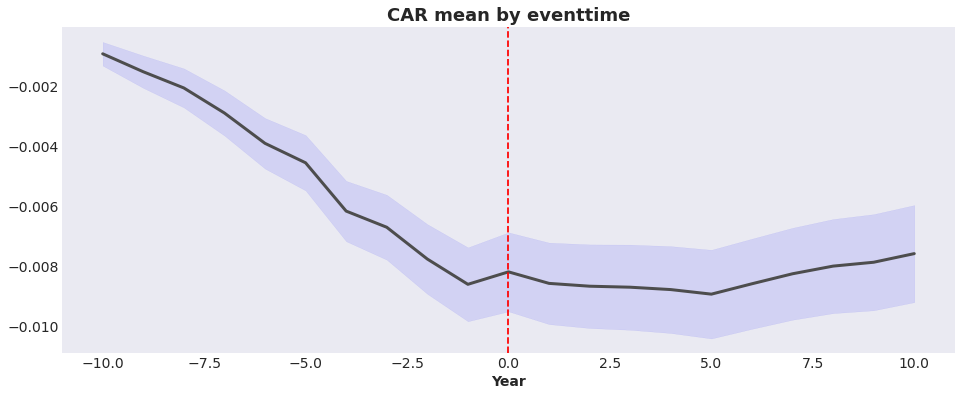

In [25]:
fig = plt.figure(figsize=(16,6))
ax = plt.subplot(111)
plt.style.use('seaborn')
colormap = plt.cm.get_cmap('twilight') 
plt.tick_params(labelsize=14) # set both x and y axes tick size to 14
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.title('CAR mean by eventtime', fontsize=18, fontweight='bold')
ax.plot(car['evttime'], car['car_m'],c=".3", linewidth=3)
ax.axvline(0, linestyle='--', c='r')
ax.fill_between(car['evttime'], (car['car_m']-car['ci']), (car['car_m']+car['ci']), color='b', alpha=.1)
plt.savefig('./Plot/car_20.png')